Install required scraping libraries (can take 5 minutes)

Scrape for S&P Constituents and Grab Wikipedia Page

In [1]:
import pandas as pd
import html5lib
from bs4 import BeautifulSoup
import requests
# Scrape the entire S&P500 list from Wikipedia into a Pandas DataFrame;
ticker_list = pd.read_html(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# print(ticker_list)

df = ticker_list[0]
# Drop a few unwanted columns of data;
# df.drop(columns = ['SEC filings', 'Date first added', 'Founded'], inplace = True)
# Fill out CIK codes by converting to string then adding in 0's up to 10 digits.
df.CIK = df.CIK.astype(str)
df['CIK'] = df['CIK'].str.zfill(10)
request = requests.get(
'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df['WIKI_URL'] = ''
soup = BeautifulSoup(request.content)
main_table = soup.find(id='constituents')
table = main_table.find('tbody').findAll('tr')
table = table[1:]
base_url = 'https://en.wikipedia.org'
url_list = []
for item in table:
    url = base_url + str(item.findAll('a')[1]['href'])
    url_list.append(url)

df['WIKI_URL'] = url_list
df = df[df["Symbol"]!="POOL"].reset_index(drop=True)
df.tail()
df["Search"] = df["WIKI_URL"].str.split("https://en.wikipedia.org/").apply(lambda x:x[1].split('/')[1])
#df[df["WIKI_URL"]]
import json
apps = []

for name in df["Search"].to_list():
  r = requests.get("https://en.wikipedia.org/w/api.php?action=query&format=json&titles="+name+"&redirects", allow_redirects=False)
  data = json.loads(r.text)
  try:
    dal = data["query"]["redirects"][0]["to"]
  except:
    try:
      dal = data["query"]["normalized"][0]["to"]
    except:
      dal = name
  apps.append(dal)
df["clean_search"] = apps


In [2]:
df["Search"]=df["Search"].apply(lambda x: x.replace("_", " "))
df.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,WIKI_URL,Search,clean_search
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,https://en.wikipedia.org/wiki/3M,3M,3M
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,https://en.wikipedia.org/wiki/A._O._Smith,A. O. Smith,A. O. Smith
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories,Abbott Laboratories,Abbott Laboratories
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie,AbbVie,AbbVie
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,https://en.wikipedia.org/wiki/Accenture,Accenture,Accenture


Now we want to use a pre-built scraper to grab the appropriate data on the MSCI website. To learn more about the scraper you can go and visit [this](https://github.com/austinjhunt/msci_esg/blob/master/msci_esg/ratefinder.py) python repository. This scraper package broke, this is a normal part of coding, let's ignore this part, and go straight to the data from an earlier export below.

In [3]:
# ## SCRAPER doesn't work perfectly (few scrapers do), move on to data section
# from msci_esg.ratefinder import ESGRateFinder
# import pandas as pd
# from selenium import webdriver

# driver = webdriver.PhantomJS('phantomjs')

# # Create an ESGRateFinder object, optionally passing in debug=True for more print statements
# ratefinder = ESGRateFinder()

# # Call the ratefinder object's get_esg_rating method, passing in the Apple stock symbol and
# # a JS timeout of 5 seconds (this is how long the Selenium web driver should wait for JS to execute
# # before scraping content)

# rep_full = {}
# for tick in df["Symbol"].head(15).to_list():
#   try:
#     response = ratefinder.get_esg_rating(
#         symbol=tick,
#         js_timeout=5
#     )
#     rep_full[tick]=response
#     print("success "+tick)
#   except:
#     print("fail "+tick)
#     continue

In [4]:
!wget https://open-data.s3.filebase.com/rep_full.p

--2023-11-08 02:14:24--  https://open-data.s3.filebase.com/rep_full.p
Resolving open-data.s3.filebase.com (open-data.s3.filebase.com)... 135.148.54.72, 135.148.54.52, 135.148.54.71
Connecting to open-data.s3.filebase.com (open-data.s3.filebase.com)|135.148.54.72|:443... 

connected.
HTTP request sent, awaiting response... 200 OK
Length: 108374 (106K) [application/octet-stream]
Saving to: 'rep_full.p.2'

rep_full.p.2        100%[===================>] 105.83K  --.-KB/s    in 0.03s   

2023-11-08 02:14:24 (2.97 MB/s) - 'rep_full.p.2' saved [108374/108374]



In [5]:
import pickle
import pandas as pd

rep_full = pickle.load(open("rep_full.p", "rb"))
test= pd.DataFrame.from_dict(rep_full)
df= pd.DataFrame.from_dict(rep_full)

In [6]:
df.head()

,MMM,AOS,ABT,ABBV,ACN,ATVI,AYI,ADBE,AAP,AMD,...,WYNN,XEL,XRX,XLNX,XL,XYL,YUM,ZBH,ZION,ZTS
rating-paragraph,3M is a leader among 36 companies in the indus...,A. O. Smith is average among 24 companies in t...,NaN,AbbVie is average among 39 companies in the bi...,Accenture is average among 143 companies in th...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,XYLEM is a leader among 51 companies in the in...,NaN,Zimmer Biomet is a laggard among 93 companies ...,NaN,Zoetis is a leader among 99 companies in the p...
rating-history-paragraph,"3M's rating remains unchanged since August, 2017.",A. O. Smith's rating remains unchanged since F...,NaN,AbbVie's rating remains unchanged since Octobe...,"Accenture was downgraded in December, 2020.",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,XYLEM's rating remains unchanged since Februar...,NaN,"Zimmer Biomet was upgraded in May, 2020.",NaN,"Zoetis was upgraded in March, 2021."
current,"{'esg_rating': 'aaa', 'esg_category': 'leader'}","{'esg_rating': 'bbb', 'esg_category': 'average'}",NaN,"{'esg_rating': 'a', 'esg_category': 'average'}","{'esg_rating': 'a', 'esg_category': 'average'}",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",NaN,"{'esg_rating': 'b', 'esg_category': 'laggard'}",NaN,"{'esg_rating': 'aa', 'esg_category': 'leader'}"
history,"{'sep-16': 'aaa', 'aug-17': 'aaa', 'aug-18': '...","{'feb-17': 'bbb', 'feb-18': 'bb', 'feb-19': 'b...",NaN,"{'oct-16': 'bbb', 'oct-17': 'bbb', 'oct-18': '...","{'jun-17': 'aaa', 'jun-18': 'aaa', 'mar-19': '...",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"{'feb-17': 'aa', 'feb-18': 'aa', 'feb-19': 'aa...",NaN,"{'dec-16': 'ccc', 'dec-17': 'ccc', 'dec-18': '...",NaN,"{'sep-17': 'aa', 'dec-18': 'a', 'jun-19': 'a',..."


In [7]:
df = df[df.index=="current"].dropna(axis=1).T

In [8]:
df["current"][0]

{'esg_rating': 'aaa', 'esg_category': 'leader'}

In [9]:
df.iloc[0][0]["esg_rating"]

'aaa'

In [10]:
df["risk"] = df["current"].apply(lambda x: x["esg_rating"])

In [11]:
rep = {"ccc":7, "b":6, "bb":5, "bbb":4, "a":3, "aa":2, "aaa":1}

In [12]:
df.index.name = "Ticker"

In [13]:
df=df.replace({"risk": rep})

In [14]:
df["risk"] = df["risk"]/df["risk"].max()

In [15]:
df = df.reset_index()

In [16]:
df.head()

,Ticker,current,risk
0,MMM,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
1,AOS,"{'esg_rating': 'bbb', 'esg_category': 'average'}",0.571429
2,ABBV,"{'esg_rating': 'a', 'esg_category': 'average'}",0.428571
3,ACN,"{'esg_rating': 'a', 'esg_category': 'average'}",0.428571
4,AES,"{'esg_rating': 'a', 'esg_category': 'average'}",0.428571


In [17]:
df.sort_values("risk")

,Ticker,current,risk
0,MMM,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
89,ECL,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
101,EXPD,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
123,GWW,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
154,JCI,"{'esg_rating': 'aaa', 'esg_category': 'leader'}",0.142857
...,...,...,...
203,NWSA,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000
204,NWS,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000
83,DISH,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000
152,SJM,"{'esg_rating': 'ccc', 'esg_category': 'laggard'}",1.000000


In [18]:
tickers = " ".join(list(df['Ticker']))

In [19]:
import yfinance as yf

yfdata=yf.download(tickers,start="2018-01-01",end="2021-01-01")
print(yfdata.head())

[*********************100%%**********************]  296 of 296 completed


24 Failed downloads:
['DISCA', 'FISV', 'PKI', 'VAR', 'FB', 'KSU', 'CTXS', 'RE', 'FBHS', 'CERN', 'MON', 'COG', 'ABC', 'MYL', 'ADS', 'ANTM', 'LB', 'AGN', 'STI', 'ALXN']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B', 'WYN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-01-01 -> 2021-01-01)')
['PX', 'CHK']: Exception("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1609477200")



                     Adj Close                                        \
                             A        AAL       ABBV ABC         ACN   
Date                                                                   
2018-01-02 00:00:00  64.734879  51.647564  74.990402 NaN  140.888611   
2018-01-03 00:00:00  66.381973  51.014027  76.163902 NaN  141.538879   
2018-01-04 00:00:00  65.884010  51.335667  75.729546 NaN  143.214783   
2018-01-05 00:00:00  66.937386  51.316170  77.047844 NaN  144.396194   
2018-01-08 00:00:00  67.081024  50.809349  75.813370 NaN  145.550110   

                                                                     ...  \
                           ADI         ADP ADS        AEE       AES  ...   
Date                                                                 ...   
2018-01-02 00:00:00  80.850525  102.931908 NaN  49.885036  8.989432  ...   
2018-01-03 00:00:00  81.853554  104.050049 NaN  49.628742  8.981170  ...   
2018-01-04 00:00:00  81.763985  105.043961

ccc MNST SJM
b ABC ABC
bb ALXN T
bbb A AFL
a ABBV AES
aa ALLE LNT
aaa ADS ADS


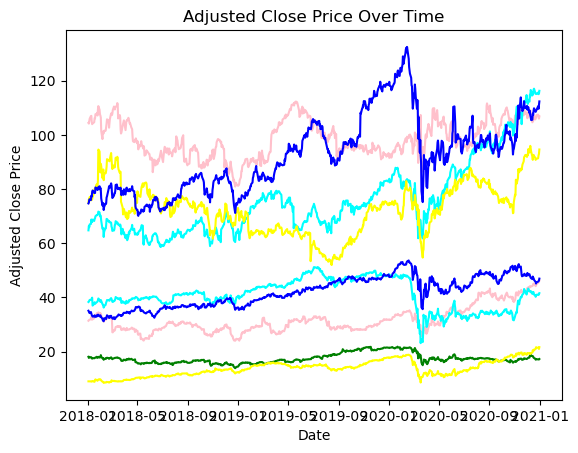

ccc: pink
b: black
bb: green
bbb: cyan
a: yellow
aa: blue
aaa: red


In [20]:
import matplotlib.pyplot  as plt
import random
colors = ['red', 'blue', 'yellow', 'cyan', 'green', 'black', 'pink']
legend = {}
def plot(data1, data2, rating):
    plt.plot(data1.index, data1, label=f'{rating} Adjusted Close', color = colors[rep[rating] - 1])
    plt.plot(data2.index, data2, label=f'{rating} Adjusted Close', color = colors[rep[rating] - 1])
    plt.title('Adjusted Close Price Over Time')
    legend[rating] = colors[rep[rating] - 1]
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')

for key in rep:
    ticker1 = list(df[df['current'].apply(lambda x : x['esg_rating'] == key)]['Ticker'])[random.randrange(0,3)]
    ticker2 = list(df[df['current'].apply(lambda x : x['esg_rating'] == key)]['Ticker'])[random.randrange(0,3)]
    plot(yfdata['Adj Close'][ticker1],yfdata['Adj Close'][ticker2], key)
    print(key, ticker1, ticker2)
plt.show()
for key in legend:
    print(f"{key}: {legend[key]}")

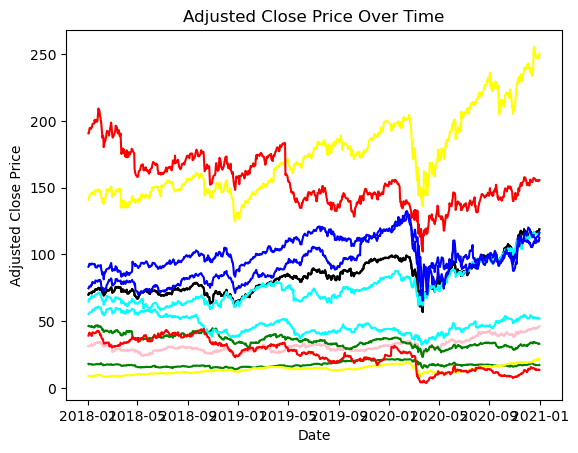

ccc: pink
b: black
bb: green
bbb: cyan
a: yellow
aa: blue
aaa: red

Above, I graphed the change in closing stock price for 2 random companies from each rating over the time interval. I was hoping to find some sort of interesting facts or movements in the graph. I think it's interesting that all of the companieswere increasing up until about 2020, then hit a sharp decline and rose back up. It seems like COVID shocked the market into a recession but the stimulus checks and government initiatives made it come back. I was surpised that red (triple A ESG) did not perform better. One of them started low and didn't get better while the other started high, went down, and didn't come back up. I would have thought that the triple A ESG would have a high closing price because they are highly invested in. My last analysis was that most of the companies with a low rating (Bs, CCC, and A) are very close to each other in terms of closing price, but The double A and Triple A have a wide disparity for closing price. I'm not sure why this is the case, maybe because they're at opposite ends of the market?

In [21]:
# formula must
    # Minimize risk ESG
    # Incentivise buying when closing price is going down
    # Incentivise selling when closing price is going up
open_close = yfdata[['Open', 'Adj Close']]

In [22]:
for stock in open_close["Adj Close"].columns:
    open_close[('10 AVG', stock)] = open_close['Adj Close'][stock].rolling(window=10).mean()

/var/folders/mn/15m_21d906xb2924c26v260h0000gn/T/ipykernel_22058/2773332945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_close[('10 AVG', stock)] = open_close['Adj Close'][stock].rolling(window=10).mean()


In [23]:
open_close.head()

Open                                         \
                             A        AAL        ABBV ABC         ACN   
Date                                                                    
2018-01-02 00:00:00  67.419998  52.330002   97.139999 NaN  153.500000   
2018-01-03 00:00:00  67.620003  52.860001   98.550003 NaN  152.990005   
2018-01-04 00:00:00  69.540001  52.480000  100.070000 NaN  155.000000   
2018-01-05 00:00:00  68.730003  52.779999   99.339996 NaN  156.610001   
2018-01-08 00:00:00  69.730003  52.599998  101.279999 NaN  157.369995   

                                                                  ... 10 AVG  \
                           ADI         ADP ADS        AEE    AES  ...     WM   
Date                                                              ...          
2018-01-02 00:00:00  89.239998  116.029999 NaN  58.980000  10.87  ...    NaN   
2018-01-03 00:00:00  90.279999  116.180000 NaN  58.160000  10.85  ...    NaN   
2018-01-04 00:00:00  91.870003  117.629997 NaN  57.959999  10.84  ...    NaN   
2018-01-05 00:00:00  91.519997  118.550003 NaN  57.619999  10.86  ...    NaN   
2018-01-08 00:00:00  91.809998  118.370003 NaN  57.610001  10.90  ...    NaN   

                                                         
                    WMB WMT  WU  WY WYN XOM XYL ZBH ZTS  
Date                                                     
2018-01-02 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2018-01-03 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2018-01-04 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2018-01-05 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2018-01-08 00:00:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 888 columns]

In [25]:
import pandas as pd
import numpy as np
import yfinance as yf

stocks = open_close['Adj Close'].columns
# Initialize signals for each stock
for stock in stocks:
    open_close[('Signal', stock)] = 0

# Generate signals based on crossover for each stock
for stock in stocks:
    open_close.loc[open_close[('10 AVG', stock)] > open_close[('Adj Close', stock)], ('Signal', stock)] = 1  # buy signal
    open_close.loc[open_close[('10 AVG', stock)] < open_close[('Adj Close', stock)], ('Signal', stock)] = -1  # Sell signal

profits = {stock:0 for stock in stocks}
intermediate_stocks = {stock: [0,0] for stock in stocks}
cum_cost, cum_rev = 0,0
# Backtest the strategy for each stock
for index, row in open_close.iterrows():
    for stock in stocks:
        if row[('Signal', stock)] == 1:  # Buy signal
            shares_bought = 10
            intermediate_stocks[stock][0] += shares_bought*row[('Adj Close', stock)]
            intermediate_stocks[stock][1] += shares_bought
        elif row[('Signal', stock)] == -1:  # Sell signal
            shares_held = intermediate_stocks[stock][1]
            rev = shares_held * row[('Open', stock)]
            cost = intermediate_stocks[stock][0]
            profit = rev-cost
            profits[stock] += profit
            intermediate_stocks[stock] = [0,0]
            cum_cost += cost
            cum_rev += rev
totalProfit = sum(list(profits.values()))
print(f'Made ${totalProfit: .2f}')
cumulative_return = (cum_rev - cum_cost) / cum_cost * 100
print(f"Cumulative Return: {cumulative_return:.2f}%")



/var/folders/mn/15m_21d906xb2924c26v260h0000gn/T/ipykernel_22058/700820191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_close[('Signal', stock)] = 0


Made $4955606.3096753135
Cumulative Return: 6.59%
